In [1]:
import collections
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
sns.set(style="darkgrid")
import tensorflow 
import warnings
warnings.filterwarnings("ignore")
from glob import glob
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import losses, optimizers
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Activation, Flatten, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from zipfile import ZipFile


In [2]:
images_path ='C:\\Users\\Loga\\Downloads\\plant-seedlings-classification.zip'
with ZipFile(images_path, 'r') as zip:
    zip.extractall('CV_data')

In [3]:
dataset = 'C:\\Users\\Loga\\Downloads\\CV_data\\plant-seedlings-classification\\train\\'
img_data = []
img_label = []
labels = []
df = pd.DataFrame(columns=['Name','Species','Image','Shape'])
for species in os.listdir(dataset):
    if species!= '.DS_Store':           
        labels.append(species)        
        for fname in os.listdir(os.path.join(dataset, species)):
            temp = cv2.imread(os.path.join(dataset, species, fname))
            dimensions = temp.shape
#             temp = cv2.resize(temp, (dimensions[0], dimensions[1])) 
            img_data.append(temp)
            img_label.append(species)
            
            df.loc[len(df.index)] = [fname , species, temp, dimensions] 
df


,Name,Species,Image,Shape
0,0050f38b3.png,Black-grass,"[[[27, 50, 80], [18, 42, 71], [36, 57, 83], [4...","(196, 196, 3)"
1,0183fdf68.png,Black-grass,"[[[37, 43, 55], [37, 43, 54], [40, 46, 57], [4...","(388, 388, 3)"
2,0260cffa8.png,Black-grass,"[[[24, 32, 45], [21, 30, 44], [22, 30, 45], [2...","(886, 886, 3)"
3,05eedce4d.png,Black-grass,"[[[51, 84, 108], [56, 89, 112], [54, 88, 110],...","(117, 117, 3)"
4,075d004bc.png,Black-grass,"[[[165, 162, 162], [165, 161, 163], [160, 157,...","(471, 471, 3)"
...,...,...,...,...
4745,fc293eacb.png,Sugar beet,"[[[98, 94, 97], [93, 88, 94], [87, 82, 86], [8...","(548, 548, 3)"
4746,fc441208c.png,Sugar beet,"[[[35, 63, 92], [38, 67, 96], [34, 64, 94], [1...","(182, 182, 3)"
4747,fed9406b2.png,Sugar beet,"[[[44, 56, 72], [52, 63, 75], [53, 65, 75], [4...","(431, 431, 3)"
4748,fef5e7066.png,Sugar beet,"[[[144, 141, 145], [143, 139, 143], [146, 142,...","(1005, 1005, 3)"


Enter number of images to be displayed:5
[ 536 3948  307  358 3237]


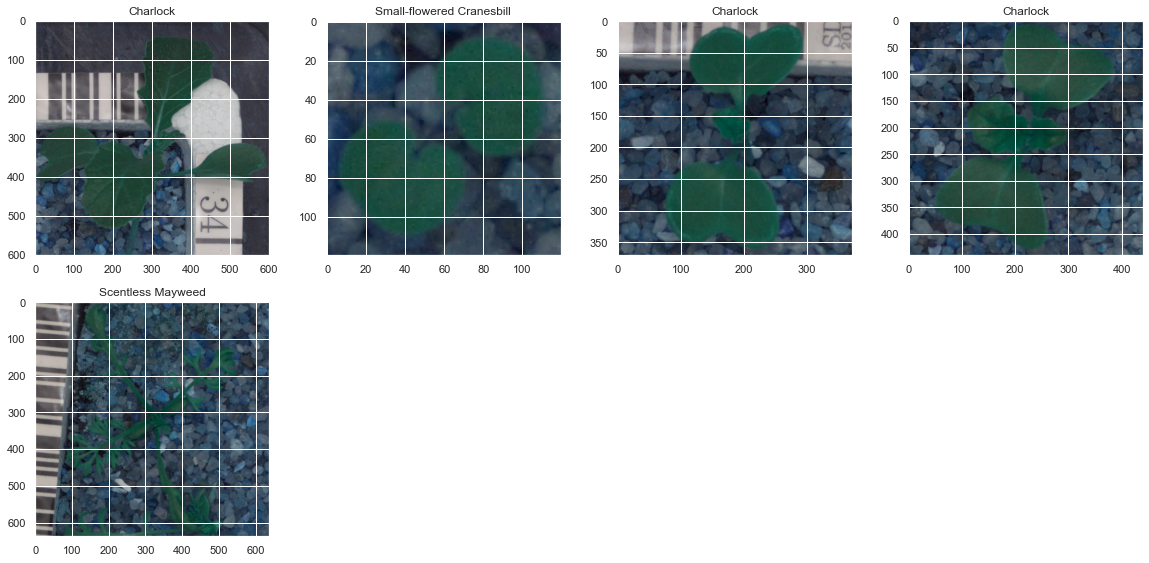

In [4]:
def gen_chart(count):
    
    rand = np.random.randint(0, len(img_data),count) 
    print(rand)
    plt.figure(figsize=(20, 5*len(rand)))
    for i,j in enumerate(rand):
        plt.subplot(len(rand), 4, i+1)
        plt.imshow(img_data[j])  
        plt.title("{}".format(img_label[j]))
    
while True:
    try:
        n = int(input('Enter number of images to be displayed:'))
        if n == 0:
            print('Enter non-zero number. Try again')
            print()
        elif n < 0:
            print('Enter positive number. Try again')
            print()
        else:
            break
    except ValueError:
        print('\nPlease enter numbers only. Try again')
        print()

gen_chart(n)


In [5]:
X = np.array(img_data)
y = np.array(img_label)

print('\nImage data : ', X.shape, y.shape)


Image data :  (4750,) (4750,)


In [6]:
Labels = np.unique(y)  
NumberOfLabels = len(Labels)  
print('\nTotal number of labels : ', NumberOfLabels)
print('\nLabels : ', Labels)
lencoder   = LabelEncoder()
y  = lencoder.fit_transform(y)
print('\nAfter encoding of labels: ', y)


Total number of labels :  12

Labels :  ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']

After encoding of labels:  [ 0  0  0 ... 11 11 11]


In [7]:

width, height, channels = (128, 128, 3)
X_resized = np.zeros((X.shape[0], width, height, channels))

for i in range(X.shape[0]):
    X_resized[i,:,:] = cv2.resize(X[i], dsize=(width, height))

X = X_resized.reshape(X_resized.shape[0], width, height, channels)

X.shape

(4750, 128, 128, 3)

In [8]:
X = X.astype('float32')

X = X/255

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('\nTraining data : ', X_train.shape, y_train.shape)  # TRAIN

print('\nTesting data : ', X_test.shape, y_test.shape) # TEST

print('\nTraining data =',round(100*X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]),2),"% of total data")

print('\nTesting data =',round(100*X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]),2),"% of total data")


Training data :  (3800, 128, 128, 3) (3800,)

Testing data :  (950, 128, 128, 3) (950,)

Training data = 80.0 % of total data

Testing data = 20.0 % of total data


**Model building**

**Model1**

In [10]:
model_epochs = 15
model_1 = Sequential()

model_1.add(BatchNormalization(input_shape = (width, height, channels)))

model_1.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (width, height, channels)))
model_1.add(MaxPooling2D(pool_size = 2))


model_1.add(Convolution2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Flatten()) 

# fully connected layer
model_1.add(Dense(units = 64,activation = 'relu'))

# Classification layer
model_1.add(Dense(units = NumberOfLabels, activation = 'softmax')) 


optimizer = Adam()
model_1.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_1.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                        

**Model2**

In [11]:
model_2 = Sequential()

model_2.add(BatchNormalization(input_shape = (128, 128, 3)))

model_2.add(Convolution2D(filters = 64, kernel_size = 3, activation ='relu', input_shape = (128, 128, 3))) 
model_2.add(MaxPooling2D(pool_size = 3))


model_2.add(Convolution2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = 3))

model_2.add(Convolution2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = 3))

model_2.add(Flatten()) 

# fully connected layer
model_2.add(Dense(units = 64,activation = 'relu'))
model_2.add(Dense(units = 32,activation = 'relu'))
model_2.add(Dense(units = 16,activation = 'relu'))

# Classification layer
model_2.add(Dense(units = NumberOfLabels, activation = 'softmax')) 
from tensorflow.keras.optimizers import Adam
optimizer = Adam()
model_2.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

**Model 3**

In [12]:
model_3 = Sequential()

model_3.add(BatchNormalization(input_shape = (128,128,3)))

model_3.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (128,128 ,3))) 
model_3.add(MaxPooling2D(pool_size = 2))

model_3.add(Convolution2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = 2))

model_3.add(Convolution2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = 3))

model_3.add(Convolution2D(filters = 256, kernel_size = 2, padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = 2))

model_3.add(Flatten()) 

# fully connected layer
model_3.add(Dense(units = 128,activation = 'relu'))
model_3.add(Dense(units = 64, activation = 'relu'))
model_3.add(Dense(units = 32, activation = 'relu'))
model_3.add(Dense(units = 16, activation = 'relu'))
model_3.add(Dense(units = 8, activation = 'relu'))

model_3.add(Dense(units = NumberOfLabels, activation = 'softmax')) 
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model_3.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        32832     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                      

**Model training**

**Model 1**

In [13]:
MODEL1=model_1.fit(X_train, y_train, epochs = model_epochs, validation_data = (X_test, y_test), initial_epoch=0)

test_score = model_1.evaluate(X_test, y_test)
train_score = model_1.evaluate(X_train, y_train)

test_score[1] = format(100*test_score[1],'.3g')
train_score[1] = format(100*train_score[1],'.3g')

accuracy_a = pd.DataFrame({'Model'         : ['CNN Model 1'], 
                         'Test Accuracy' : [test_score[1]], 
                         'Train Accuracy': [train_score[1]],
                        })
accuracy_a

Epoch 1/15
119/119 [==============================] - 61s 474ms/step - loss: 2.6186 - accuracy: 0.1182 - val_loss: 2.4624 - val_accuracy: 0.1284
Epoch 2/15
119/119 [==============================] - 54s 455ms/step - loss: 2.2985 - accuracy: 0.2158 - val_loss: 2.1184 - val_accuracy: 0.3842
Epoch 3/15
119/119 [==============================] - 49s 413ms/step - loss: 1.3688 - accuracy: 0.5592 - val_loss: 1.2503 - val_accuracy: 0.6516
Epoch 4/15
119/119 [==============================] - 60s 502ms/step - loss: 0.7678 - accuracy: 0.7550 - val_loss: 0.9146 - val_accuracy: 0.6916
Epoch 5/15
119/119 [==============================] - 59s 494ms/step - loss: 0.4475 - accuracy: 0.8642 - val_loss: 0.9395 - val_accuracy: 0.7137
Epoch 6/15
119/119 [==============================] - 50s 420ms/step - loss: 0.2237 - accuracy: 0.9371 - val_loss: 1.0332 - val_accuracy: 0.7116
Epoch 7/15
119/119 [==============================] - 54s 450ms/step - loss: 0.1062 - accuracy: 0.9734 - val_loss: 1.0922 - val_ac

,Model,Test Accuracy,Train Accuracy
0,CNN Model 1,71.3,100


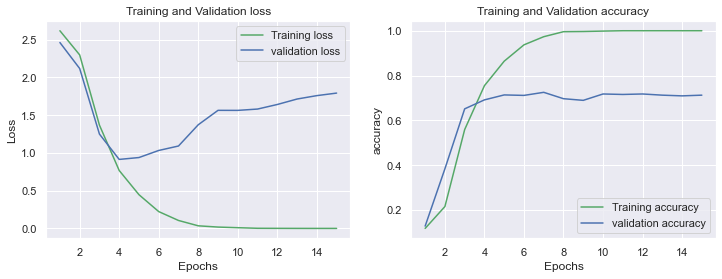

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

loss_train = MODEL1.history['loss']
loss_val = MODEL1.history['val_loss']
epochs = range(1,model_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
Acc_train = MODEL1.history['accuracy']
Acc_val = MODEL1.history['val_accuracy']
epochs = range(1,model_epochs+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend();

**Model 2**

In [15]:
MODEL_2=model_2.fit(X_train, y_train, epochs = model_epochs, validation_data = (X_test, y_test), initial_epoch=0)


test_score = model_2.evaluate(X_test, y_test)
train_score = model_2.evaluate(X_train, y_train)

test_score[1] = format(100*test_score[1],'.3g')
train_score[1] = format(100*train_score[1],'.3g')

    
accuracy_a.loc[1] = ['CNN Model 2', test_score[1], train_score[1]]
accuracy_a

Epoch 1/15
119/119 [==============================] - 54s 450ms/step - loss: 2.2269 - accuracy: 0.2405 - val_loss: 2.2682 - val_accuracy: 0.2926
Epoch 2/15
119/119 [==============================] - 52s 435ms/step - loss: 1.5853 - accuracy: 0.4468 - val_loss: 1.7784 - val_accuracy: 0.4084
Epoch 3/15
119/119 [==============================] - 396s 3s/step - loss: 1.2461 - accuracy: 0.5750 - val_loss: 1.3269 - val_accuracy: 0.5421
Epoch 4/15
119/119 [==============================] - 47s 394ms/step - loss: 0.9934 - accuracy: 0.6611 - val_loss: 1.0043 - val_accuracy: 0.6600
Epoch 5/15
119/119 [==============================] - 53s 448ms/step - loss: 0.8362 - accuracy: 0.7116 - val_loss: 0.8140 - val_accuracy: 0.7105
Epoch 6/15
119/119 [==============================] - 51s 430ms/step - loss: 0.7109 - accuracy: 0.7568 - val_loss: 0.8242 - val_accuracy: 0.7189
Epoch 7/15
119/119 [==============================] - 49s 409ms/step - loss: 0.6298 - accuracy: 0.7818 - val_loss: 0.7251 - val_accu

,Model,Test Accuracy,Train Accuracy
0,CNN Model 1,71.3,100
1,CNN Model 2,77.8,90.7


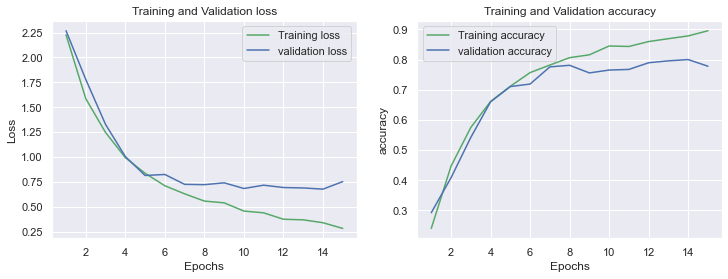

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

loss_train = MODEL_2.history['loss']
loss_val = MODEL_2.history['val_loss']
epochs = range(1,model_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)

Acc_train = MODEL_2.history['accuracy']
Acc_val = MODEL_2.history['val_accuracy']
epochs = range(1,model_epochs+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend();


**Model 3**

In [17]:
MODEL3=model_3.fit(X_train, y_train, epochs = model_epochs, validation_data = (X_test, y_test), initial_epoch=0)

test_score = model_3.evaluate(X_test, y_test)
train_score = model_3.evaluate(X_train, y_train)

test_score[1] = format(100*test_score[1],'.3g')
train_score[1] = format(100*train_score[1],'.3g')

accuracy_a.loc[2] = ['CNN Model 3', test_score[1], train_score[1]]
accuracy_a

Epoch 1/15
119/119 [==============================] - 96s 807ms/step - loss: 2.4387 - accuracy: 0.1000 - val_loss: 2.4237 - val_accuracy: 0.1937
Epoch 2/15
119/119 [==============================] - 133s 1s/step - loss: 2.0988 - accuracy: 0.3355 - val_loss: 2.3735 - val_accuracy: 0.1800
Epoch 3/15
119/119 [==============================] - 102s 855ms/step - loss: 1.6896 - accuracy: 0.4495 - val_loss: 1.7250 - val_accuracy: 0.4263
Epoch 4/15
119/119 [==============================] - 107s 898ms/step - loss: 1.3177 - accuracy: 0.5742 - val_loss: 1.2284 - val_accuracy: 0.6274
Epoch 5/15
119/119 [==============================] - 102s 858ms/step - loss: 1.0947 - accuracy: 0.6339 - val_loss: 1.0148 - val_accuracy: 0.6800
Epoch 6/15
119/119 [==============================] - 101s 854ms/step - loss: 0.9289 - accuracy: 0.6887 - val_loss: 0.8604 - val_accuracy: 0.7189
Epoch 7/15
119/119 [==============================] - 111s 933ms/step - loss: 0.8085 - accuracy: 0.7305 - val_loss: 0.7642 - val

,Model,Test Accuracy,Train Accuracy
0,CNN Model 1,71.3,100
1,CNN Model 2,77.8,90.7
2,CNN Model 3,83.2,93


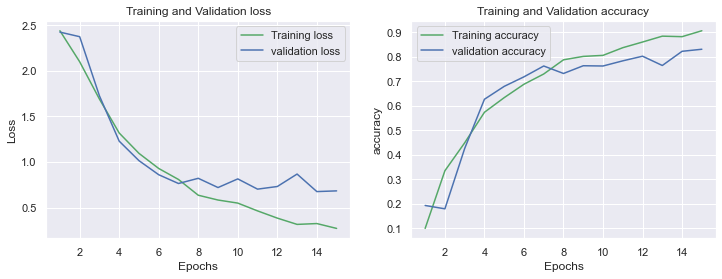

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

loss_train = MODEL3.history['loss']
loss_val = MODEL3.history['val_loss']
epochs = range(1,model_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
Acc_train = MODEL3.history['accuracy']
Acc_val = MODEL3.history['val_accuracy']
epochs = range(1,model_epochs+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend();


In [40]:
max_accuracy = accuracy_a.loc[accuracy_a['Test Accuracy'] == accuracy_a['Test Accuracy'].max()]


print('Best performing model:\n')
max_accuracy

Best performing model:



,Model,Test Accuracy,Train Accuracy
2,CNN Model 3,83.2,93


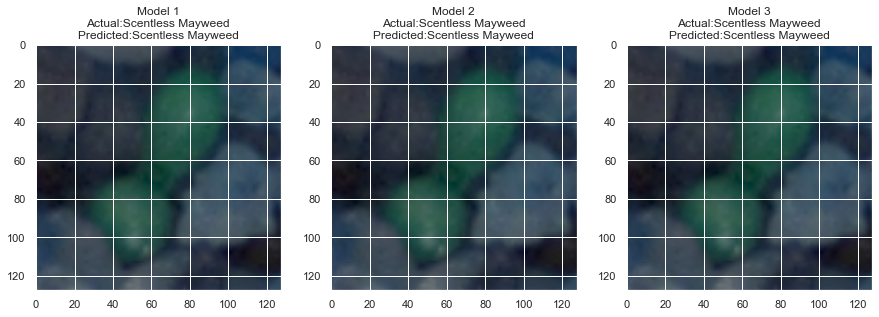

In [19]:
test_range = X_test.shape[0]
n = random.randint(0, test_range)

pred = model_1.predict(X_test[n].reshape(1,128,128,3))

plt.figure(figsize=(15, 22))
plt.subplot(1,3,1)
plt.imshow(X_test[n],cmap='Greys')
plt.title('Model 1\nActual:'+labels[y_test[n]]+'\nPredicted:'+labels[pred.argmax()])


pred = model_2.predict(X_test[n].reshape(1,128,128,3))

plt.subplot(1,3,2)
plt.imshow(X_test[n],cmap='Greys')
plt.title('Model 2\nActual:'+labels[y_test[n]]+'\nPredicted:'+labels[pred.argmax()])


pred = model_3.predict(X_test[n].reshape(1,128,128,3))

plt.subplot(1,3,3)
plt.imshow(X_test[n],cmap='Greys')
plt.title('Model 3\nActual:'+labels[y_test[n]]+'\nPredicted:'+labels[pred.argmax()]);

### 

In [20]:
import tflearn.datasets.oxflower17 as oxflower17
X, y = oxflower17.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
print('Number of images:', X.shape[0])
print('Shape of images: Height:', X.shape[1], ' Width:', X.shape[2], ' Channel:', X.shape[3])

Number of images: 1360
Shape of images: Height: 224  Width: 224  Channel: 3


In [22]:
y_ML = np.argmax(y, axis=1) 

classes = np.unique(y_ML)  
NumberOfClass = len(classes)  
print('\nTotal number of classes : ', NumberOfClass)


counter = collections.Counter(y_ML)
df_count = pd.DataFrame.from_dict(counter,orient='index').reset_index()

df_count = df_count.sort_values(by=['index'], ascending=True)
df_count.rename(columns = {'index':'Class', 0:'Count'}, inplace = True)

df_count.style.hide()  


Total number of classes :  17


Class,Count
0,80
1,80
2,80
3,80
4,80
5,80
6,80
7,80
8,80
9,80


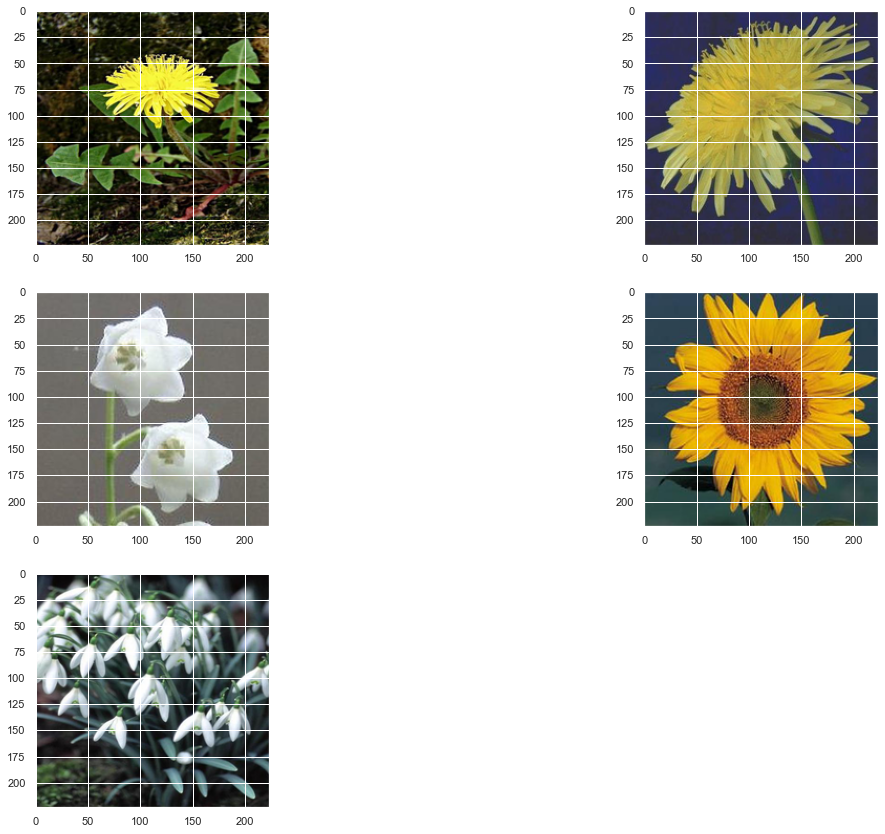

In [23]:
def gen_chart(val):
    
    rand = np.random.randint(0, len(X), val) 
    plt.figure(figsize=(20, 5*len(rand)))
    for i,j in enumerate(rand):
        plt.subplot(len(rand), 2, i+1)
        plt.imshow(X[j])  
    

gen_chart(5)

In [24]:
img_org = random.choice(X)

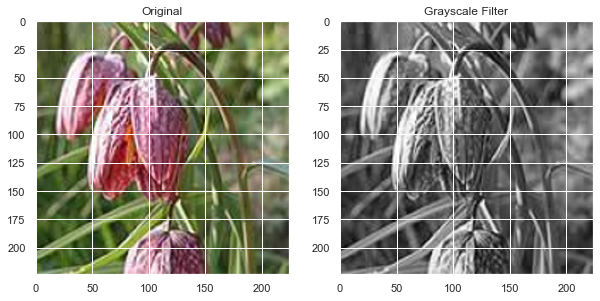

In [25]:
gray_image = cv2.cvtColor(img_org, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img_org,cmap='gray')
plt.title('Original')


plt.subplot(1,2,2)
plt.imshow(gray_image,cmap='gray')
plt.title('Grayscale Filter')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


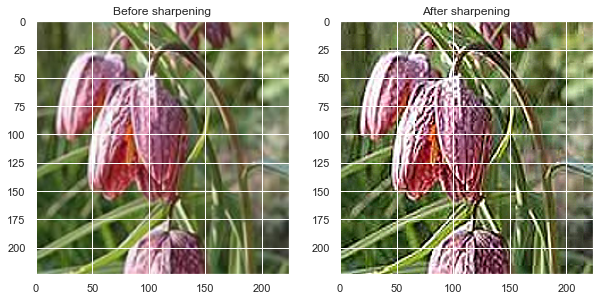

In [26]:
sharp_filter = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]])
sharp_filter

sharp_img = cv2.filter2D(img_org,kernel=sharp_filter,ddepth=-1)


plt.figure(figsize=(10, 10))

plt.subplot(1,2,1)
plt.imshow(img_org)
plt.title('Before sharpening')

plt.subplot(1,2,2)
plt.imshow(sharp_img)
plt.title('After sharpening')

plt.show()

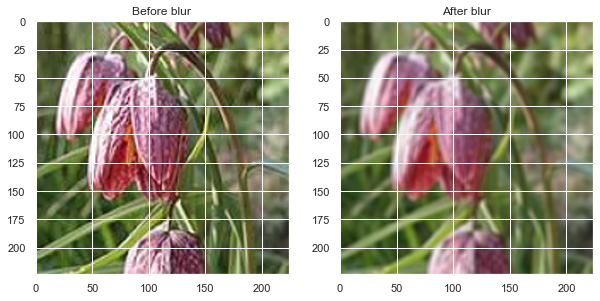

In [27]:
blur_img = cv2.GaussianBlur(img_org,ksize=(5,5),sigmaX=20,sigmaY=10)

plt.figure(figsize=(10, 10))

plt.subplot(1,2,1)
plt.imshow(img_org)
plt.title('Before blur')

plt.subplot(1,2,2)
plt.imshow(blur_img)
plt.title('After blur')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


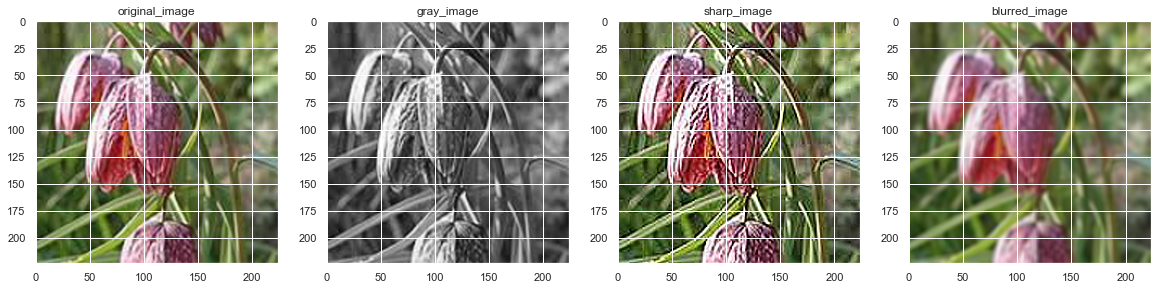

In [28]:
img_title = ['original_image', 'gray_image', 'sharp_image', 'blurred_image']

plt.figure(figsize=(20,20))
for i,img in enumerate([img_org, gray_image, sharp_img, blur_img]):
    plt.subplot(1,4,i+1)
    plt.title(img_title[i])
    plt.imshow(img,cmap='gray')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ML, test_size=0.2, random_state=42, stratify=y_ML)

print('\nTraining data : ', X_train.shape, y_train.shape)  

print('\nTesting data : ', X_test.shape, y_test.shape) 

print('\nTraining data =',round(100*X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]),2),"% of total data")

print('\nTesting data =',round(100*X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]),2),"% of total data")


X_train_ML = X_train.astype('float32')
width, height, channels = X_train_ML.shape[1], X_train_ML.shape[2], X_train_ML.shape[3]
# X_train_ML = X_train_ML.reshape((X_train_ML.shape[0], width, height, channels))
X_train_ML = X_train_ML.reshape((X_train_ML.shape[0], width*height*channels))

X_train_ML = X_train_ML/255


X_test_ML = X_test.astype('float32')
width, height, channels = X_test_ML.shape[1], X_test_ML.shape[2], X_test_ML.shape[3]
# X_test_ML = X_test_ML.reshape((X_test_ML.shape[0], width, height, channels))
X_test_ML = X_test_ML.reshape((X_test_ML.shape[0], width*height*channels))

X_test_ML = X_test_ML/255


print('\nReshaped Training data : ', X_train_ML.shape, y_train.shape)  
print('\nReshaped Testing data : ', X_test_ML.shape, y_test.shape) 


Training data :  (1088, 224, 224, 3) (1088,)

Testing data :  (272, 224, 224, 3) (272,)

Training data = 80.0 % of total data

Testing data = 20.0 % of total data

Reshaped Training data :  (1088, 150528) (1088,)

Reshaped Testing data :  (272, 150528) (272,)


In [30]:
LogR = LogisticRegression()
LogR.fit(X_train_ML, y_train)

y_pred_lrt=LogR.predict(X_train_ML)
LogR_Accuracy_Train = format(100*accuracy_score(y_true=y_train, y_pred=y_pred_lrt) , '.3g')

y_pred_lrte = LogR.predict(X_test_ML)
LogR_Accuracy_Test  = format(100*accuracy_score(y_true=y_test, y_pred=y_pred_lrte), '.3g')

accuracy_b          = pd.DataFrame({'Model'         : ['Logistic Regression'], 
                                  'Test Accuracy' : [LogR_Accuracy_Test], 
                                  'Train Accuracy': [LogR_Accuracy_Train],
                                })
accuracy_b

,Model,Test Accuracy,Train Accuracy
0,Logistic Regression,33.8,50.7


In [31]:
k=[BernoulliNB,GaussianNB]
for i in range (len(k)):
    NB_Classifier = k[i]()
    NB_Classifier.fit(X_train_ML, y_train)
    print ('kernel is =',k[i], '\tScore=',NB_Classifier.score(X_test_ML, y_test))

NB = GaussianNB()
NB.fit(X_train_ML, y_train)

y_pred_tr_NB = NB.predict(X_train_ML)
NB_Accuracy_Train = format(100*accuracy_score(y_train, y_pred_tr_NB), '.3g')

y_pred_ts_NB = NB.predict(X_test_ML)
NB_Accuracy_Test = format(100*accuracy_score(y_test, y_pred_ts_NB, normalize = True), '.3g')

accuracy_b.loc[1] = ['Gaussian NB', NB_Accuracy_Test, NB_Accuracy_Train]
accuracy_b

kernel is = <class 'sklearn.naive_bayes.BernoulliNB'> 	Score= 0.14705882352941177
kernel is = <class 'sklearn.naive_bayes.GaussianNB'> 	Score= 0.3492647058823529


,Model,Test Accuracy,Train Accuracy
0,Logistic Regression,33.8,50.7
1,Gaussian NB,34.9,51.2


In [32]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 


y_train_NN = pd.get_dummies(y_train)
y_test_NN = pd.get_dummies(y_test)

nn_model = Sequential()  
nn_model.add(BatchNormalization(input_shape = (224*224*3,)))  ### Batch_Norm Layer
    
nn_model.add(Dense(256, activation='relu')) ###Multiple Dense units with Relu activation
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dropout(rate=0.2))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(rate=0.2))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(17, activation='softmax'))
    
adam = optimizers.Adam(learning_rate=1e-3)
nn_model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy']) ### Loss function = Categorical cross entropy

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
nnmodel = nn_model.fit(X_train_ML, y_train_NN, validation_data=(X_test_ML, y_test_NN), epochs=model_epochs, batch_size=8, verbose=1)

test_score = nn_model.evaluate(X_test_ML, y_test_NN)
train_score = nn_model.evaluate(X_train_ML, y_train_NN)

test_score[1] = format(100*test_score[1],'.3g')
train_score[1] = format(100*train_score[1],'.3g')


accuracy_b.loc[2] = ['Neural Network', test_score[1], train_score[1]]
accuracy_b

Train on 1088 samples, validate on 272 samples
Epoch 1/15
1088/1088 [==============================] - 33s 30ms/sample - loss: 2.7519 - acc: 0.1443 - val_loss: 2.8603 - val_acc: 0.0625
Epoch 2/15
1088/1088 [==============================] - 30s 28ms/sample - loss: 2.4440 - acc: 0.2160 - val_loss: 2.7985 - val_acc: 0.0809
Epoch 3/15
1088/1088 [==============================] - 26s 24ms/sample - loss: 2.2745 - acc: 0.2537 - val_loss: 2.5572 - val_acc: 0.1397
Epoch 4/15
1088/1088 [==============================] - 33s 30ms/sample - loss: 2.1162 - acc: 0.2739 - val_loss: 2.1977 - val_acc: 0.2831
Epoch 5/15
1088/1088 [==============================] - 31s 29ms/sample - loss: 2.0311 - acc: 0.3217 - val_loss: 1.9509 - val_acc: 0.3419
Epoch 6/15
1088/1088 [==============================] - 27s 25ms/sample - loss: 1.8879 - acc: 0.3456 - val_loss: 1.9481 - val_acc: 0.3235
Epoch 7/15
1088/1088 [==============================] - 31s 29ms/sample - loss: 1.8271 - acc: 0.3778 - val_loss: 1.8869 - val

,Model,Test Accuracy,Train Accuracy
0,Logistic Regression,33.8,50.7
1,Gaussian NB,34.9,51.2
2,Neural Network,44.5,75.4


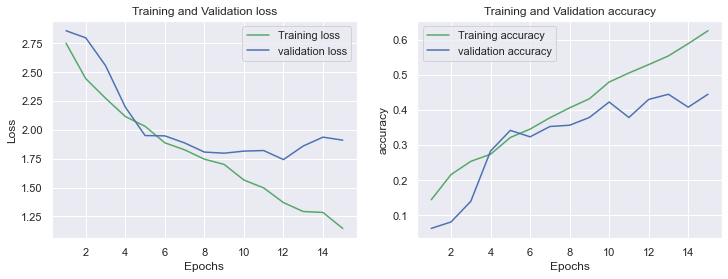

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

loss_train = nnmodel.history['loss']
loss_val = nnmodel.history['val_loss']
epochs = range(1,model_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
Acc_train = nnmodel.history['acc']
Acc_val = nnmodel.history['val_acc']
epochs = range(1,model_epochs+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend();


In [35]:
cnn_model = Sequential()

cnn_model.add(BatchNormalization(input_shape = (224,224,3)))



cnn_model.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (224,224 ,3))) 
cnn_model.add(MaxPooling2D(pool_size = 2))

cnn_model.add(Convolution2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = 2))

cnn_model.add(Convolution2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = 3))

cnn_model.add(Convolution2D(filters = 256, kernel_size = 2, padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = 2))

cnn_model.add(Flatten()) 

# fully connected layer
cnn_model.add(Dense(units = 128,activation = 'relu'))
cnn_model.add(Dense(units = 64, activation = 'relu'))
cnn_model.add(Dense(units = 32, activation = 'relu'))
cnn_model.add(Dense(units = 16, activation = 'relu'))
cnn_model.add(Dense(units = 8, activation = 'relu'))

cnn_model.add(Dense(units = NumberOfClass, activation = 'softmax')) 
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 111, 111, 64)      32832     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                      

In [36]:
cnnmodel=cnn_model.fit(X_train, y_train, epochs = model_epochs, validation_data = (X_test, y_test), initial_epoch=0)

test_score = cnn_model.evaluate(X_test, y_test)
train_score = cnn_model.evaluate(X_train, y_train)

test_score[1] = format(100*test_score[1],'.3g')
train_score[1] = format(100*train_score[1],'.3g')


accuracy_b.loc[3] = ['CNN', test_score[1], train_score[1] ]
accuracy_b

Train on 1088 samples, validate on 272 samples
Epoch 1/15
1088/1088 [==============================] - 114s 105ms/sample - loss: 2.8373 - acc: 0.0524 - val_loss: 2.8333 - val_acc: 0.0551
Epoch 2/15
1088/1088 [==============================] - 99s 91ms/sample - loss: 2.8288 - acc: 0.0506 - val_loss: 2.8256 - val_acc: 0.0882
Epoch 3/15
1088/1088 [==============================] - 110s 101ms/sample - loss: 2.7570 - acc: 0.0873 - val_loss: 2.7654 - val_acc: 0.1397
Epoch 4/15
1088/1088 [==============================] - 100s 92ms/sample - loss: 2.6189 - acc: 0.1471 - val_loss: 2.6315 - val_acc: 0.1544
Epoch 5/15
1088/1088 [==============================] - 91s 84ms/sample - loss: 2.4670 - acc: 0.1618 - val_loss: 2.4763 - val_acc: 0.1691
Epoch 6/15
1088/1088 [==============================] - 93s 85ms/sample - loss: 2.2308 - acc: 0.2426 - val_loss: 2.2385 - val_acc: 0.2610
Epoch 7/15
1088/1088 [==============================] - 93s 86ms/sample - loss: 2.0307 - acc: 0.3015 - val_loss: 2.1774 

,Model,Test Accuracy,Train Accuracy
0,Logistic Regression,33.8,50.7
1,Gaussian NB,34.9,51.2
2,Neural Network,44.5,75.4
3,CNN,50.7,79.8


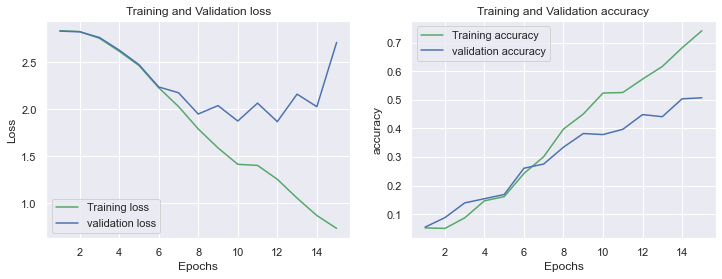

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)

loss_train = cnnmodel.history['loss']
loss_val = cnnmodel.history['val_loss']
epochs = range(1,model_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
Acc_train = cnnmodel.history['acc']
Acc_val = cnnmodel.history['val_acc']
epochs = range(1,model_epochs+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend();


In [41]:
max_accuracy = accuracy_b.loc[accuracy_b['Test Accuracy'] == accuracy_b['Test Accuracy'].max()]


print('Best performing model:\n')
max_accuracy

Best performing model:



,Model,Test Accuracy,Train Accuracy
3,CNN,50.7,79.8


Predicted Label is  7


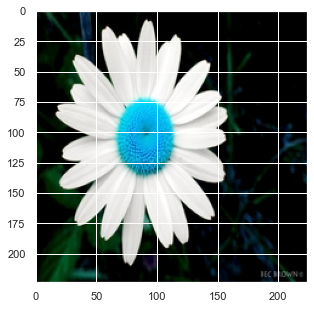

In [38]:
pred_img = cv2.imread('Prediction.jpg')

plt.figure(figsize=(5, 5))
plt.imshow(pred_img)

pred_img = cv2.resize(pred_img,(224,224),3)
pred_img = pred_img.reshape(1, 224, 224,3)

pred_b = cnn_model.predict(pred_img)

print('Predicted Label is ', classes[pred_b.argmax()])